# Example for DIVAnd with automatic data download

* Notebook to create a gridded climatology from in situ observation using DIVAnd (data interpolating variational analysis, n-dimension, [doi:10.5194/gmd-7-225-2014](https://doi.org/10.5194/gmd-7-225-2014)) 
* Runs on a OpenStack cluster at CINECA (EuDAT) using the storage from B2DROP
* SeaDataCloud will use notebook to create climatologies which will also serve as a complete documentation show the products have been generate
* SeaDataNet will provide a dedicated machine-to-machine interface during the SeaDataCloud project
* As a proof of concept, we use the World Ocean Database as example for bulk access remote data

The path list LOAD_PATH should include the folder containing the module `WorldOceanDatabase`.

```julia
push!(LOAD_PATH, "path/to/module")
```

where `path/to/module` of the folder containing `WorldOceanDatabase.jl`

For the bathymetry data see instructions at https://github.com/gher-ulg/divand.jl/#example-data.
Installation instructions of `divand.jl` are available here https://github.com/gher-ulg/divand.jl.


In [30]:
# here the module is in the current working directory
push!(LOAD_PATH, pwd());

## Load julia modules

In [31]:
using PyPlot
import WorldOceanDatabase
import divand
using Interact

User parameters for the analysis are first defined

In [ ]:
# resolution
dx = dy = 0.25   # medium size test
#dx = dy = 1.    # small test

# vectors defining the longitude and latitudes grids
# Here longitude and latitude correspond to the Mediterranean Sea
lonr = -7:dx:37
latr = 30:dy:46

# depth levels
depthr = [0.,10.,20.]

# time range of the in-situ data
timerange = [Date(2016,1,1),Date(2016,12,31)]

# months for the climatology (January, February,...)
timer = [1.,2.,3.]

In [32]:
# Name of the variable
varname = "Temperature"

# Email for downloading the data
email = "a.barth@ulg.ac.be"

# path to save the results (will be created if necessary)
basedir = expanduser("~/Downloads/WOD/Med-2016")

# bathymetry
bathname = joinpath(dirname(@__FILE__),"../Data/divand-example-data/Global/Bathymetry/gebco_30sec_16.nc")

# bathymetry is a global data set
isglobal = true

# error variance of the observations (normalized by the error variance of the background field)
epsilon2 = 0.1;

Size of the space-time domain and the correlation length in all spatial dimensions and the temporal dimension.
The vertical correlation length increases with depth.


In [33]:
# size of the domain
sz = (length(lonr),length(latr),length(depthr),length(timer))

# horizontal correlation length in meters
lenx = fill(300_000.,sz) # m
leny = fill(300_000.,sz) # m


# vertical correlation length in meters
# correlation increases at depth
lenz = Array{Float64}(sz)
for n = 1:sz[4]
    for k = 1:sz[3]
        for j = 1:sz[2]
            for i = 1:sz[1]
                lenz[i,j,k,n] = 10 + depthr[k]/5
            end
        end
    end
end

# correlation time-scale in month
lent = fill(1.,sz); # month

## Data download

* World Ocean Database: example for bulk access data by simulating a web-user
* SeaDataNet: will provide a dedicated machine-to-machine interface during the SeaDataCloud project

Comment next line (or skip this cell) if the data has already been downloaded

In [34]:
#WorldOceanDatabase.download(lonr,latr,timerange,varname,email,basedir)

Load the data into memory and perform (potentially) an additional subsetting

In [35]:
# load all data under basedir as a double-precision floating point variable
val,lon,lat,depth,time,ids = WorldOceanDatabase.load(Float64,basedir,varname)

# additional sub-setting and discard bogus negative temperatures
sel = ((val .> 0 )
       .& (minimum(depthr) .<= depth .<= maximum(depthr))
       .& (minimum(timer) .<= Dates.month.(time) .<= maximum(timer)))

val = val[sel]
lon = lon[sel]
lat = lat[sel]
depth = depth[sel]
time = time[sel]
ids = ids[sel];

## Plot the data

In [ ]:
# contour for plots
cxi,cyi,mask0 = divand.load_mask(bathname,isglobal,minimum(lonr),maximum(lonr),1/60,minimum(latr),maximum(latr),1/60,0)

# plot observations
plotmonth = 1
plotdepth = 10
    
title("Temperature observations (month $(plotmonth), around depth $(plotdepth) m)")
# around means here +/-5 meters
selection = (abs.(depth - plotdepth) .<= 5) .& (Dates.month.(time) .== plotmonth);
    
contourf(cxi,cyi,mask0',levels  = [0.,0.5],colors = [[.5,.5,.5]])
scatter(lon[selection],lat[selection],20,val[selection],cmap = "jet")
colorbar(orientation="horizontal")

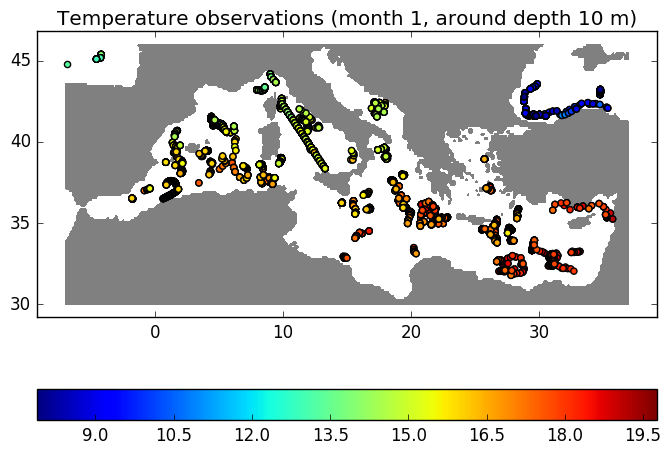

In [36]:
# sets the correct aspect ratio
gca()[:set_aspect](1/cos(mean(latr) * pi/180))

Setup the domain using the bathymetry from the file `bathname`.

In [37]:
# define the geo-temporal domain
# mask indicates wether a grid point is land or sea (based on the bathymetry)
# pm,pn,po,pp: correspond to the resolution of grid in space and time
# xi,yi,zi,ti: the location of the grid cells as 4D-arrays
mask,(pm,pn,po,pp),(xi,yi,zi,ti) = divand.domain(bathname,isglobal,lonr,latr,depthr,timer)

# size of the domain
@show size(mask)

# convert time to month
time2 = Dates.month.(time)

# average over longitude and latitude for the background estimate
toaverage=[true,true,false,false]

# compute the background and the anomalies
@time fmb,vaa = divand.divand_averaged_bg(mask,(pm,pn,po,pp),(xi,yi,zi,ti),(lon,lat,depth,time2),val,(lenx,leny,4*lenz,4*lent),epsilon2*10,toaverage)

# perform the analysis
@time fi,erri=divand.divandgo(mask,(pm,pn,po,pp),(xi,yi,zi,ti),(lon,lat,depth,time2),vaa,(lenx,leny,lenz,lent),epsilon2)

# add the background
fanalysis = fi + fmb

# verify the range (excluding land points)
@show extrema(fanalysis[mask])

size(mask) = (177, 65, 3, 3)
size(mask) = (177, 65, 3, 3)
(extrema(vaanalyzed), sum(sm.obsout), extrema(faanom)) = ((14.586604339536294, 16.375817088189166), 0, (-8.123015917971767, 4.4046403249846))
  0.755234 seconds (860.09 k allocations: 77.192 MiB, 2.95% gc time)
csteps = [1, 1, 1, 1]
problemsize = 1872.0
epsilon = 5.858252779857413
stepsize = [301, 209, 2, 3]
(size(mask), size(windowlist)) = ((177, 65, 3, 3), (1,))
size(windowpoints[1]) = (177,)
 

 2.245147 seconds (1.04 M allocations: 353.604 MiB, 3.93% gc time)
(al, dot(fgs - fs, fgs - fs) / dot(fs, fs), dot(al * fgs - fs, al * fgs - fs) / dot(fs, fs)) = (1.0085871893543015, 0.02549515283198285, 0.02542450632878299)
  0.284200 seconds (599 allocations: 78.699 MiB, 4.74% gc time)
(al, dot(fgs - fs, fgs - fs) / dot(fs, fs), dot(al * fgs - fs, al * fgs - fs) / dot(fs, fs)) = (0.9897744764502873, 0.0018555569985727112, 0.0017490107029071668)
 27.302466 seconds (60.72 M allocations: 8.804 GiB, 20.36% gc time)
extrema(fanalysis[mask]) = (5.575920276366297, 22.586288072296597)


(5.575920276366297, 22.586288072296597)

Plot the first depth level and the first time instance (`k` is the depth index and `n` is the time index)

Interact.Options{:SelectionSlider,Int64}(55: "input-19" = 2 Int64 , "k", 2, "2", Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3), Dict(2=>"2",3=>"3",1=>"1")), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Int64}(57: "input-20" = 2 Int64 , "n", 2, "2", Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3), Dict(2=>"2",3=>"3",1=>"1")), Any[], Any[], true, "horizontal")

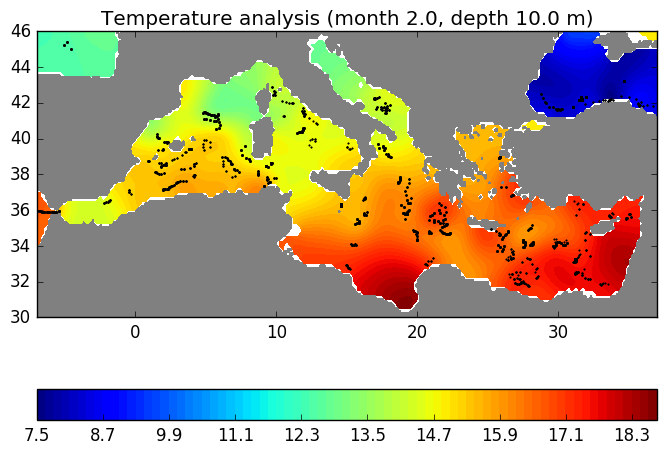

In [41]:
f = figure()
@manipulate for k = 1:length(depthr), n = 1:length(timer)
    withfig(f) do
        title("Temperature analysis (month $(timer[n]), depth $(depthr[k]) m)")
        contourf(xi[:,:,k,n],yi[:,:,k,n],fanalysis[:,:,k,n],100,cmap="jet")
        colorbar(orientation="horizontal")

        # plot land
        contourf(cxi,cyi,mask0',levels  = [0.,0.5],colors = [[.5,.5,.5]])

        # plot observation location
        selection = (abs.(depth - depthr[k]) .<= 5) .& (Dates.month.(time) .== timer[n]);
        plot(lon[selection],lat[selection],"k.",ms=2)

        # sets the correct aspect ratio
        gca()[:set_aspect](1/cos(mean(latr) * pi/180))
    end
end

## Result export

Save the results in a NetCDF

In [39]:
divand.divand_save("temperature.nc", mask, "temperature", fanalysis);

filename = "temperature.nc"
